# Multi RAG Chatbot with LangGraph and Astra DB
* Notebook by Adam Lang
* Date: 1/16/2025

# Overview
* In this notebook I will implement an end-to-end Generative AI application using Retrieval Augmented Generation (RAG) over a Vector DB (Astra DB) as well as utilizing a multi-agent framework.

# **Multi-agent architecture**
1. Agent to search wikipedia
2. Agent to search vector DB
3. Agent to retrieve results
4. Agent that acts as the ROUTER to route user queries to the correct source (wiki-search tool or vector DB).


# Architecture
* The overall workflow as you see in my diagram below:
1. User enters query
2. `START` node is initiated.
3. Query sent to `Router`
4. Query will be routed to Vector DB or to Agents depending upon logic defined.
5. Retrieved information from Vector DB and/or Agents is then sent to LLM
6. LLM synthesizes or abstracts information into desired output to answer user query.
7. `END` node is reached.

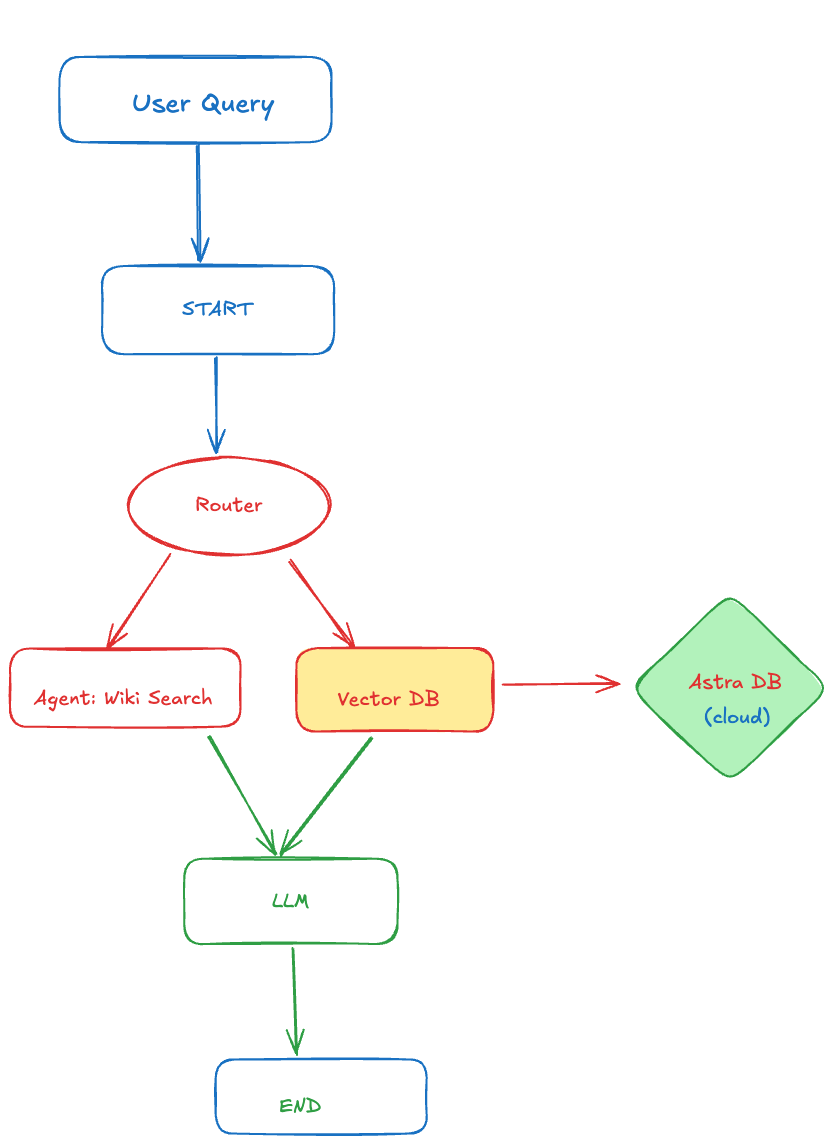

# Install Dependencies
* Below we are installed `cassio` which is important for interacting with Astra DB vector database, langchain and the LLM application.
  * More about cassio: https://cassio.org/start_here/

In [19]:
%%capture
!pip install langchain langgraph cassio

In [20]:
%%capture
!pip install -U langchain_community tiktoken langchain-groq langchainhub langchain langgraph langchain_huggingface

In [39]:
%%capture
!pip install wikipedia ## search tool we will use

# Vector Database Setup
* Setup Astra DB instance

In [21]:
import cassio
## connection for Astra DB
ASTRA_DB_APPLICATION_TOKEN=<your token here>
ASTRA_DB_ID=<your id here>
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN,
            database_id=ASTRA_DB_ID)



## Build Vector Index
* Now we build the vector index for Astra DB vector database.
* First we chunk the text --> then create vectors and store them as embeddings within Astra DB.

### Process
* We are going to load 3 specific web based documents, split and chunk them and load them into the vector database.

### Splitting on Tokens
* Below we are going to split on tokens using the `tiktoken` function `from_tiktoken_encoder`.
* Splitting on tokens allows us to handle and monitor token limits in LLMs.
  * This is important for seamless operations and optimal performance.
  * It is best practice to count the number of tokens after creating the chunks.

* Tiktoken was created by OpenAI and is a fast BPE (byte pair encoder).
  * It can be used to track the number of tokens used and better suits OpenAI models, but not just OpenAI other similar decoder models with similar BPE tokenizers.
  * Here the text split is done on the characters passed in and the chunk size is measured by the tiktoken tokenizer.
* This is a great review article on splitting techniques: https://medium.com/@sushmithabhanu24/retrieval-in-langchain-part-2-text-splitters-2d8c9d595cc9

In [22]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader



# documents to index
## these are web urls
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

## load documents
docs = [WebBaseLoader(url).load() for url in urls]
## iterate over docs
doc_list=[item for sublist in docs for item in sublist]
print(doc_list)
## split text
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500,
                                                                     chunk_overlap=0)
## apply text_splitter to docs
docs_split = text_splitter.split_documents(doc_list)


[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [23]:
# iterate over each chunk in docs_split list and count average tokens per chunk
import tiktoken

## token encoding
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo") # Choose an appropriate encoding

## iterate over chunks and count tokens
total_tokens = 0
for chunk in docs_split:
  total_tokens += len(encoding.encode(chunk.page_content))

## calculate avg tokens per chunk
average_tokens_per_chunk = total_tokens / len(docs_split) if len(docs_split) > 0 else 0

print(f"Average tokens per chunk: {average_tokens_per_chunk}")

Average tokens per chunk: 333.6818181818182


Summary
* Knowing the average tokens per chunk is ~334, we should consider this for our embedding choice dimensions.

## Convert Chunks to Embeddings
* Given the avg tokens per chunk is ~334, using a model that maps to a smaller dimensional space would be appropriate.
* We can use this SentenceTransformer model: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

In [24]:
## HF notebook login
from huggingface_hub import notebook_login

notebook_login()

In [26]:
from langchain_huggingface import HuggingFaceEmbeddings

## load embedding model from HF
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

## Insert Embeddings into Astra DB
* Move embeddings to vector database.
* This is the part of our flow diagram I just created:

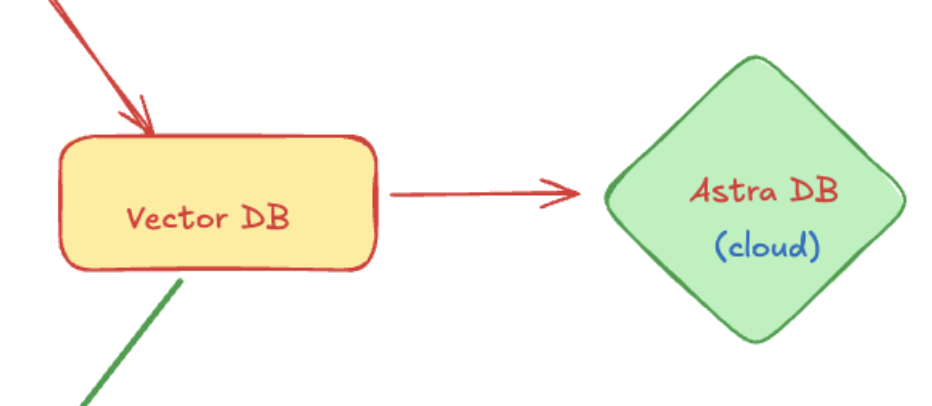

In [27]:
from langchain.vectorstores.cassandra import Cassandra

## code to insert data into Vector DB
astra_vector_db = Cassandra(embedding=embeddings,
                            table_name="qa_mini_demo", ## table for embeddings
                            session=None,
                            keyspace=None)

Insert all documents into Astra DB

In [28]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper ## wrapper on top of vector store

## add docs to vector store
astra_vector_db.add_documents(docs_split)
print("Inserted %i headlines data." % len(docs_split))

## create vector index in Astra DB
astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_db)

Inserted 88 headlines data.


Create Retriever

In [30]:
## retriever
retriever=astra_vector_db.as_retriever()

## invoke retriever
retriever.invoke("What is an AI agent?")

[Document(id='b12f4407c4464ac4b7b7a9c7dd8fe4cd', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context lear

# Router Setup
* Now we have to setup the Router component.
* This routes a user query to the MOST relevant data source whether it is:
  * Vector DB...or
  * Agent with tool
* We need to create a data model for this using Pydantic.

In [32]:
## langgraph application
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field


## Router data model
class RouteQuery(BaseModel):
  """Routes a user query to most relevant data source."""

  ## data source --> vectorstore or wiki agent-tool
  ## Literal sets control over defined data values
  data_source: Literal["vectorstore", "wiki_search"] = Field(
      ...,
      description="Given a user question choose to route it to wikipedia or a vectorstore."
  )

# LLM Setup via GROQ API
* We will use an LLM from the GROQ open source API.

In [33]:
## enter GROQ API key
from getpass import getpass

GROQ_API_KEY = getpass("Enter your GROQ API KEY: ")

Enter your GROQ API KEY: ··········


In [34]:
## set up GROQ environment access
import os

os.environ['GROQ_API_KEY'] = GROQ_API_KEY

In [35]:
### set up GROQ LLM
from langchain_groq import ChatGroq

llm = ChatGroq(groq_api_key=GROQ_API_KEY, model_name="Llama-3.1-70b-Versatile")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7c1f57c921d0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7c1f57d004d0>, model_name='Llama-3.1-70b-Versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

# Initiate Router
* This infrastructure builds the router that will route the query to either the Vector DB or the Agent-Tool.

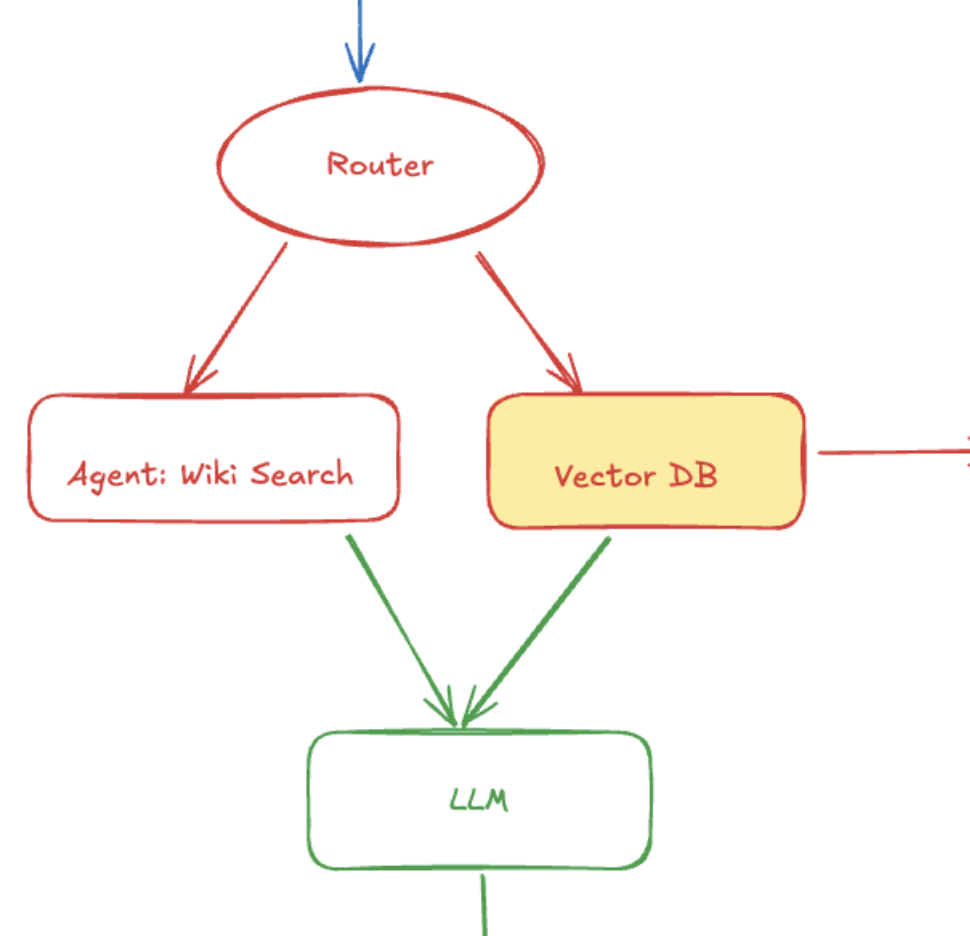

In [36]:
## structured router
struct_llm_router = llm.with_structured_output(RouteQuery)

## Prompt
system = """You are an expert at routing a user question to a vectorstore or a wikipedia search tool.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use the wiki search tool."""

## prompt template
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)
## setup question router
question_router = route_prompt | struct_llm_router

## Testing the router
* Lets see how the router handles different types of queries.

In [37]:
print(question_router.invoke(
    {
        "question": "What is an AI agent?"
    }
))

data_source='vectorstore'


In [38]:
print(question_router.invoke(
    {
        "question": "Who is the President of France?"
    }
))

data_source='wiki_search'


# Setup Agent-Tools

In [40]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

## create API wrapper
api_wrapper=WikipediaAPIWrapper(top_k_results=1,
                                doc_content_chars_max=200)
## setup wiki search tool
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [41]:
## test wiki search tool
wiki.run("Tell me about Bluey")

'Page: Bluey (TV series)\nSummary: Bluey is an Australian animated preschool television series which premiered on ABC Kids on 1 October 2018. The program was created by Joe Brumm and is produced by Quee'

# AI Agent Creation with LangGraph
* The agent connects/ties everything we just built using the graph states, nodes, and edges.

1. State function

In [43]:
## langgraph setup for AI agent
from typing  import List
from typing_extensions import TypedDict

## 1. State creation
class GraphState(TypedDict):
  """
  This is the State of the graph.

  Attributes:
    question: question or query
    generation: LLM generation
    documents: list of documents
  """
  question: str
  generation: str
  documents: List[str]

2. Retriever function

In [46]:
from langchain.schema import Document

## 2. Retriever function for graph
def retrieve(state):
  """
  Retrieve documents

  Args:
    state (dict): current graph state

  Returns:
    state (dict): new key added to state, documents, that contains retrieved docs
  """
  print("---Retrieve---")
  questions=state["question"]

  ## invoke retriever with questions
  documents = retriever.invoke(questions)

  return {"documents": documents, "questions": questions}

3. Wiki-Search tool function

In [47]:
## 3. Wiki-search tool function
def wiki_search(state):
  """
  Performs a wikipedia search based on re-phrased question.

  Args:
    state (dict): current graph state

  Returns:
    state (dict): updates documents key with appended web results
  """
  print("---wikipedia---")
  question=state['question']

  ## wiki search tool
  docs = wiki.invoke({"query": question})
  ## prindt(docs["summary"])
  wiki_results=docs
  wiki_results=Document(page_content=wiki_results)

  return {"documents": wiki_results, "question": question}

4. Router Function
* Although we created a router previously, we need a helper function to implement it within langgraph.

In [52]:
## router function implementation
def route_question(state):
  """
  Routes questions/queries to wiki search or vector DB RAG.

  Args:
    state (dict): current graph state

  Returns:
    str: next node to call

  """
  print("---ROUTE QUESTION---")
  question=state['question']
  source=question_router.invoke({"question": question})

  ## Router logic
  if source.data_source == "wiki_search":
    print("---ROUTE QUESTION TO Wiki SEARCH---")
    return "wiki_search"
  elif source.data_source == "vectorstore":
    print("---ROUTE QUESTION TO RAG VECTOR DB")
    return "vectorstore"

Summary
* We can see that we now have a multi-agent framework
1. Agent to use wiki-search tool.
2. Agent to search Astra vector DB
3. Agent to retrieve results and send to LLM for synthesis and abstraction.
4. Agent that acts as the ROUTER to route user queries to the correct source (wiki-search tool or vector DB).

# Create LangGraph Flow

In [53]:
from langgraph.graph import StateGraph, START, END

## 1. state
workflow=StateGraph(GraphState)

## 2. define nodes
workflow.add_node("wiki_search", wiki_search) ## wiki-search tool
workflow.add_node("retrieve", retrieve) ## retrieve

## 3. build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("retrieve", END)
workflow.add_edge("wiki_search", END)

## 4. compile graph
app=workflow.compile()

## Display Graph

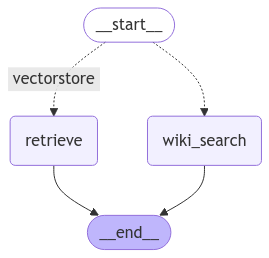

In [54]:
from IPython.display import Image, display

try:
  display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
  # This requires extra dependencies and is optional step
  pass

Summary
* We can see the full graph above except for the "Router" which is hidden and not displayed.

# Inference and Testing of App

In [63]:
from pprint import pprint

## function to test app
def test_app(question: str):
  # Run
  inputs = {
    "question": question
  }
  for output in app.stream(inputs):
    for key, value in output.items():
      # Node
      pprint(f"Node '{key}':")
      # Optional: print full state at each node
      # pprint.pprint(value['keys'], indent=2, width=80, depth=None)
    pprint("\n---\n")

  ## Final generative output
  return pprint(value['documents'])

In [64]:
## test 1 --> result should be from vector db
test_app("What is generative AI?")

---ROUTE QUESTION---


---ROUTE QUESTION TO RAG VECTOR DB
---Retrieve---
"Node 'retrieve':"
'\n---\n'
[Document(id='732bf827d4c646278f52dab8323e7424', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [65]:
## test 2 --> wiki tool
test_app("who are the avengers?")

---ROUTE QUESTION---
---ROUTE QUESTION TO Wiki SEARCH---
---wikipedia---
"Node 'wiki_search':"
'\n---\n'
Document(metadata={}, page_content='Page: Avengers: Endgame\nSummary: Avengers: Endgame is a 2019 American superhero film based on the Marvel Comics superhero team the Avengers. Produced by Marvel Studios and distributed by Walt Disney S')


In [69]:
## test 3 --> wiki tool?
test_app("What is the capital of Colorado?")

---ROUTE QUESTION---
---ROUTE QUESTION TO Wiki SEARCH---
---wikipedia---
"Node 'wiki_search':"
'\n---\n'
Document(metadata={}, page_content='Page: Denver\nSummary: Denver  ( DEN-vər) is a consolidated city and county, the capital, and most populous city of the U.S. state of Colorado. It is located in the western United States, in the South ')


In [70]:
## test 4 -->
test_app("What is chain of thought prompting?")

---ROUTE QUESTION---


---ROUTE QUESTION TO RAG VECTOR DB
---Retrieve---
"Node 'retrieve':"
'\n---\n'
[Document(id='dcd78bb557294876b16d35ad48802017', metadata={'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log"}, page_content='Self-Ask (Press et al. 2022) is a method to repeatedly p